In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import scipy.stats as stats
import seaborn as sns
from sklearn import preprocessing
from Bio.Seq import Seq
from Bio import motifs
import random

import keras
np.random.seed(1337)

from keras.preprocessing import sequence
from keras.optimizers import RMSprop
from keras.models import Sequential
from keras.layers.core import Dense
from keras.layers.core import Dropout
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.convolutional import Conv1D

import sklearn
from sklearn.linear_model import LogisticRegression

%matplotlib inline

### Parameters for plotting model results ###
pd.set_option("display.max_colwidth",100)
sns.set(style="ticks", color_codes=True)
plt.rcParams['font.weight'] = 'normal'
plt.rcParams['axes.labelweight'] = 'normal'
plt.rcParams['axes.labelpad'] = 5
plt.rcParams['axes.linewidth']= 2
plt.rcParams['xtick.labelsize']= 14
plt.rcParams['ytick.labelsize']= 14
plt.rcParams['xtick.major.size'] = 6
plt.rcParams['ytick.major.size'] = 6
plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['ytick.minor.size'] = 3
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.minor.width'] = 1
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'
plt.rcParams['axes.labelcolor'] = 'black'
plt.rcParams['axes.edgecolor'] = 'black'

Using TensorFlow backend.


## Data And Model Setup

In [42]:
def train_model(x, y, border_mode='same', inp_len=50, nodes=40, layers=3, filter_len=8, nbr_filters=120,
                dropout1=0, dropout2=0, dropout3=0, nb_epoch=3):
    ''' Build model archicture and fit.'''
    model = Sequential()
    if layers >= 1:
        model.add(Conv1D(activation="relu", input_shape=(inp_len, 4), padding=border_mode, filters=nbr_filters, kernel_size=filter_len))
    if layers >= 2:
        model.add(Conv1D(activation="relu", input_shape=(inp_len, 1), padding=border_mode, filters=nbr_filters, kernel_size=filter_len))
        model.add(Dropout(dropout1))
    if layers >= 3:
        model.add(Conv1D(activation="relu", input_shape=(inp_len, 1), padding=border_mode, filters=nbr_filters, kernel_size=filter_len))
        model.add(Dropout(dropout2))
    model.add(Flatten())

    model.add(Dense(nodes))
    model.add(Activation('relu'))
    model.add(Dropout(dropout3))
    
    model.add(Dense(1))
    model.add(Activation('linear'))

    #compile the model
    adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.compile(loss='mean_squared_error', optimizer=adam)

    model.fit(x, y, batch_size=128, epochs=nb_epoch, verbose=1)
    return model


def test_data(df, model, test_seq, obs_col, output_col='pred'):
    '''Predict mean ribosome load using model and test set UTRs'''
    
    # Scale the test set mean ribosome load
    scaler = preprocessing.StandardScaler()
    scaler.fit(df[obs_col].values.reshape(-1,1))   #LAE: .values added, pd deprecation
    
    # Make predictions
    predictions = model.predict(test_seq).reshape(-1)
    
    # Inverse scaled predicted mean ribosome load and return in a column labeled 'pred'
    df.loc[:,output_col] = scaler.inverse_transform(predictions)
    return df

def test_binary_data(df, model, test_seq, obs_col, output_col='pred'):
    # No need to reshape since values already are all 0 or 1
    # Make predictions
    predictions = model.predict(test_seq).reshape(-1)
    
    # Inverse scaled predicted mean ribosome load and return in a column labeled 'pred'
    df.loc[:,output_col] = predictions
    df.loc[:,output_col+'_error'] = df[obs_col] - df[output_col]
    return df


def one_hot_encode(df, col='utr', seq_len=50):
    # Dictionary returning one-hot encoding of nucleotides. 
    nuc_d = {'a':[1,0,0,0],'c':[0,1,0,0],'g':[0,0,1,0],'t':[0,0,0,1], 'n':[0,0,0,0]}
    
    # Creat empty matrix.
    vectors=np.empty([len(df),seq_len,4])
    
    # Iterate through UTRs and one-hot encode
    for i,seq in enumerate(df[col].str[:seq_len]): 
        seq = seq.lower()
        a = np.array([nuc_d[x] for x in seq])
        vectors[i] = a
    return vectors

def r2(x,y):
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    return r_value**2

In [223]:
#df = pd.read_pickle('../data/egfp_unmod_1.pkl')  #LAE: do not have this pickle file...?
df = pd.read_csv('../data/egfp_unmod_1.csv',index_col=0)
df.sort_values('total_reads', inplace=True, ascending=False)
df.reset_index(inplace=True, drop=True)
df = df.iloc[:280000]

# The training set has 260k UTRs and the test set has 20k UTRs.
e_test = df.iloc[:20000]
e_train = df.iloc[20000:]

# One-hot encode both training and test UTRs
seq_e_train = one_hot_encode(e_train,seq_len=50)
seq_e_test = one_hot_encode(e_test, seq_len=50)

# Scale the training mean ribosome load values
e_train.loc[:,'scaled_rl'] = preprocessing.StandardScaler().fit_transform(e_train.loc[:,'rl'].values.reshape(-1,1))

# Label the datasets
e_train.loc[:,'dataset'] = 'train'
e_test.loc[:,'dataset'] = 'test'

## Create and Train Models

In [4]:
# Load Saved Model
model = keras.models.load_model('./saved_models/main_MRL_model.hdf5') #this is the Author's model

W0923 14:07:15.090131 4455900608 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0923 14:07:15.154803 4455900608 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0923 14:07:15.179299 4455900608 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0923 14:07:15.312674 4455900608 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0923 14:07:15.324639 4455900608 deprecati

In [5]:
e_train = test_data(df=e_train,model=model,test_seq=seq_e_train,obs_col='rl',output_col='auth_pred')
e_test = test_data(df=e_test,model=model,test_seq=seq_e_test,obs_col='rl',output_col='auth_pred')

## Visualize Results

In [34]:
def jointgrid_plot(datasets,one_dataset=False,colors=[(0.3, 0.45, 0.69),'r'],title="",alphas=[0.1,0.1],
                   xheader='rl',yheader='pred',xaxislabel='Observed MRL',yaxislabel="Predicted MRL"):
    """
    Make a jointgrid scatter plot of Observed MRL vs Predicted MRL using two or more different datasets 
    colored according to the input list of colors, in a style like the author's figure. 
    If only one dataset, set the flag one_dataset to True so that datasets can be of type list without 
    getting datasets vs dataset elements confused. Bad code but hey.
    """
    data = datasets if one_dataset == True else datasets[0]
    
    g = sns.JointGrid(x=xheader, y=yheader, data=data, space=0, xlim=(1,10), ylim=(0,10), ratio=6, size=7)
    g.plot_joint(plt.scatter,s=20, color=colors[0], linewidth=0.2, alpha=str(alphas[0]), edgecolor='white')
    f = g.fig
    ax = f.gca()
    ax.set_yticks(np.arange(0,9.01, 1));
    ax.set_yticklabels(range(10),size=20);
    ax.set_xticks(np.arange(1,10.01, 1));
    ax.set_xticklabels(range(1,11),size=20);
    ax.set_ylim(0,9)
    ax.set_xlim(1,10)
    g.plot_marginals(sns.kdeplot,shade=colors[0], **{'linewidth':2, 'color':colors[0]})
    g.set_axis_labels(xaxislabel, yaxislabel, **{'size':22});

    if one_dataset == False:
        alphas = alphas if len(alphas) == len(datasets) else [alphas[0]]*len(datasets)
        for d,c,a in zip(datasets[1:],colors[1:],alphas[1:]):
            g.x = d[xheader].values
            g.y = d[yheader].values
            g.plot_joint(plt.scatter, s=20, linewidth=0.2, alpha=str(a), color=c, edgecolor='white')
            g.plot_marginals(sns.kdeplot, shade=c, **{'linewidth':2, 'color':c})
            f = g.fig

    f.suptitle(title,fontsize=20)
    
    return f

/usr/local/lib/python2.7/site-packages/seaborn/axisgrid.py:1672: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


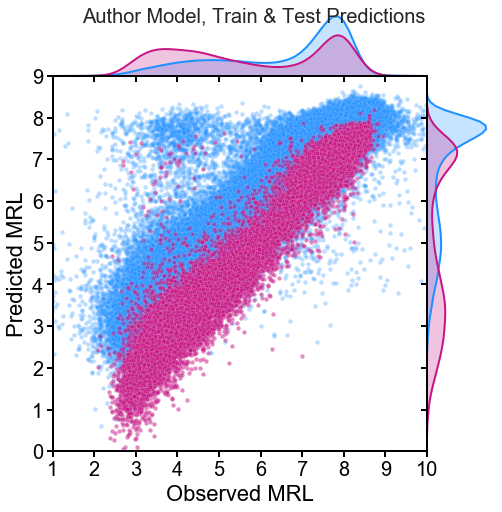

In [7]:
plot_auth = jointgrid_plot([e_train,e_test],alphas=[0.3,0.5],yheader='auth_pred',colors=['dodgerblue','mediumvioletred'],
                           title="Author Model, Train & Test Predictions")

In [8]:
# Combine Datasets so that we can split on different concepts
data = pd.concat([e_train,e_test],axis=0,sort=True)
data.loc[:,'scaled_rl'] = preprocessing.StandardScaler().fit_transform(data.loc[:,'rl'].values.reshape(-1,1))

In [237]:
# Add MFE Data Now (for later usage)
mfe_data = pd.read_csv('../mfe_dataset.csv',index_col=0)
data.sort_values(by='utr',inplace=True, ascending=False)
mfe_data.sort_values(by='utr',inplace=True, ascending=False)
data.loc[:,'mfe75'] = mfe_data['mfe75']
data.loc[:,'mfe100'] = mfe_data['mfe100']
data.loc[:,'mfe125'] = mfe_data['mfe125']

# Scale a few key values (for later usage)
for header in ['total_reads','mfe75','mfe100','mfe125']:
    scaler = preprocessing.StandardScaler()    
    data.loc[:,'scaled_'+header] = scaler.fit_transform(data.loc[:,header].values.reshape((-1,1)))

data.sort_values(by='total_reads',inplace=True, ascending=False)

In [238]:
# Isolate that off-diagonal "cluster" of low observed/high predicted MRL (Generous boundaries)
ofd = data[((data['auth_pred']-data['rl'])**2 > 3.5)
                  &(data['auth_pred']-data['rl'] > 0)
                  &(data['auth_pred'] > 6.5)] 
ond = data[~data['utr'].isin(ofd['utr'].values)]
print len(ofd), len(ond)
data.loc[:,'off_diagonal'] = [ s in ofd['utr'].values for s in data['utr'].values ]

1281 278719


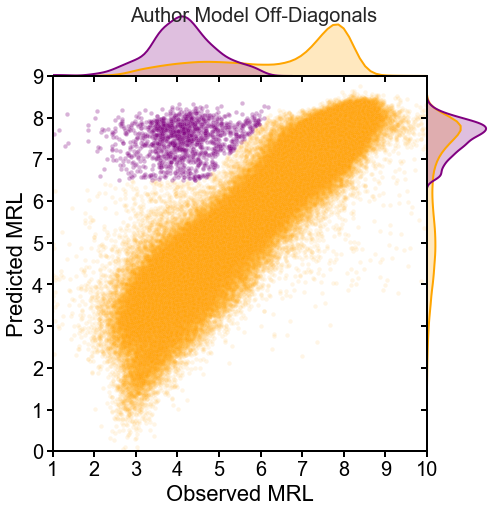

In [228]:
plot_auth2 = jointgrid_plot([ond,ofd],alphas=[0.1,0.3],yheader='auth_pred',
                            colors = ['orange','purple'],
                            title="Author Model Off-Diagonals")

## Goal: To Create a Model that Predicts Off-Diagonal Cluster Membership

- will require upsampling of the minority class (off-diagonal cluster elements), and maybe downsampling of majority class as well
- create both a smaller version of the main model that has no additional information, AND an alternate model that uses derived filter information and other info like MFE and read count

In [45]:
def count_results(df,xheader,yheader):
    d = { "true_pos":0,"true_neg":0,"false_pos":0,"false_neg":0, "total":0 }
    labels = df[xheader].values
    predictions = df[yheader].values
    rounded_predictions = np.round(predictions,1) #really basic, ignores lots of subtle errors
    d['total'] = len(labels)
    for l,p in zip(labels,rounded_predictions):
        if l == 1: # is truly pos
            if p == l:
                d['true_pos'] += 1
            else:
                d['false_neg'] += 1
        elif l == 0: # is truly neg
            if p == l:
                d['true_neg'] += 1
            else:
                d['false_pos'] += 1
        else:
            print "label not recognized"
            return 
    return d

In [239]:
# Create Test and Train Sets
ofd.sort_values('total_reads', inplace=True, ascending=False)
ofd.reset_index(inplace=True, drop=True)
ond.sort_values('total_reads', inplace=True, ascending=False)
ond.reset_index(inplace=True, drop=True)

ofd.loc[:,'off_diagonal'] = 1
ond.loc[:,'off_diagonal'] = 0

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [240]:
# Test set does not really need to be balanced, 
# if we be sure to also performance on the off-diagonal UTRs set specifically
X_test = pd.concat([ ofd[:281],ond[:19719]], axis=0, sort=True)
X_test_minority = X_test[:281]

# Train set DOES need to be balanced, however. 
# 200k seqences in total:
#     100k of 1k off-diagonals upsampled 100x
#     100k of 50k high-read-count on-diagonals + 50k low-read-count on-diagonals
X_train = pd.concat( [ pd.concat([ofd[281:]]*100), ond[19719:69719], ond[-50000:] ], axis=0, sort=True)
# Small Train Set with only 20k values
X_small_train = pd.concat( [ pd.concat([ofd[281:]]*10), ond[19719:24719], ond[-15000:-10000] ], axis=0, sort=True)

In [241]:
# Shuffle order of Train Set
np.random.seed(42)
X_train = X_train.sample(frac=1)
X_small_train = X_small_train.sample(frac=1)

X_train_seq = one_hot_encode(X_train)
X_small_train_seq = one_hot_encode(X_small_train)
X_test_seq = one_hot_encode(X_test)
X_test_minority_seq = X_test_seq[:281]

y_train = X_train['off_diagonal'].values
y_small_train = X_small_train['off_diagonal'].values
y_test = X_test['off_diagonal'].values

## Make Small Model with No Additional Information than Main Model

In [205]:
# Build the Smaller Model 
# 10 filters of kernel length 8 x 4 layers
# 20 nodes in dense layer
small_model = Sequential()
small_model.add(Conv1D(activation="relu", input_shape=(50, 4), padding="same",
                       filters=10, kernel_size=8))
small_model.add(Conv1D(activation="relu", input_shape=(50, 1), padding="same",
                       filters=10, kernel_size=8))
small_model.add(Conv1D(activation="relu", input_shape=(50, 1), padding="same",
                       filters=10, kernel_size=8))
small_model.add(Conv1D(activation="relu", input_shape=(50, 1), padding="same",
                       filters=10, kernel_size=8))
small_model.add(Flatten())
small_model.add(Dense(20))
small_model.add(Activation('relu'))
small_model.add(Dropout(0.1))
small_model.add(Dense(1))
small_model.add(Activation('sigmoid')) #sigmoid to output a binary classification btw 0 (on-diagonal) and 1 (off)

In [206]:
# Compile and Train the Smaller Model
np.random.seed(1337)
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
small_model.compile(loss='mean_squared_error', optimizer=adam)

small_model.fit(X_train_seq, y_train, batch_size=125, epochs=3, verbose=1) 
#changed batch size 128 -> 125 for even split

Epoch 1/3
200000/200000 [==============================] - 18s 91us/step - loss: 0.1454
Epoch 2/3
200000/200000 [==============================] - 16s 81us/step - loss: 0.0526
Epoch 3/3
200000/200000 [==============================] - 16s 79us/step - loss: 0.0340


## Test Small Model Meta-Predictions

In [207]:
X_train = test_binary_data(df=X_train,model=small_model,test_seq=X_train_seq,obs_col='off_diagonal',output_col='small_pred')


In [208]:
X_test = test_binary_data(df=X_test,model=small_model,test_seq=X_test_seq,obs_col='off_diagonal',output_col='small_pred')
X_test_minority = test_binary_data(df=X_test_minority,model=small_model,
                            test_seq=X_test_minority_seq,obs_col='off_diagonal',output_col='small_pred_min')

Percent below 0.5: 48.3765 %
Percent above 0.5: 51.6235 %


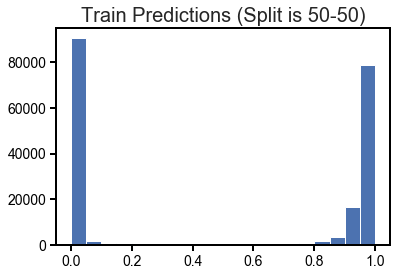

In [209]:
plt.hist(X_train['small_pred'],bins=20)
plt.title("Train Predictions (Split is 50-50)",fontsize=20)
print "Percent below 0.5:", len(X_train[X_train['small_pred'] < 0.5]) * 100.0 / len(X_train), '%'
print "Percent above 0.5:", len(X_train[X_train['small_pred'] >= 0.5]) * 100.0 / len(X_train), '%'

Percent with Error below 0.2: 95.7445 %


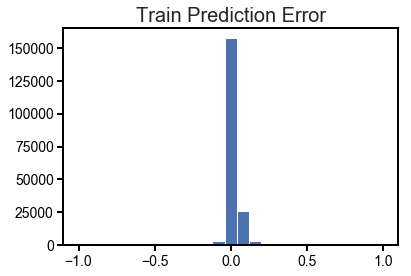

In [210]:
plt.hist(X_train['small_pred_error'],bins=25)
plt.title("Train Prediction Error",fontsize=20)
pct = len(X_train[np.abs(X_train['small_pred_error']) < 0.2]) * 100.0 / len(X_train)
print "Percent with Error below 0.2:", pct, '%'

Percent below 0.5: 94.85 %
Percent above 0.5: 5.15 %


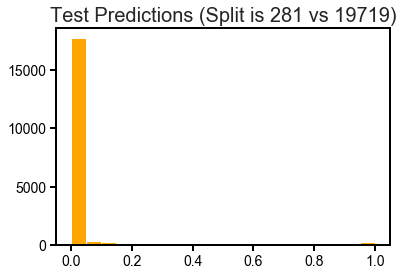

In [211]:
plt.hist(X_test['small_pred'],bins=20,color='orange')
plt.title("Test Predictions (Split is 281 vs 19719)",fontsize=20)
print "Percent below 0.5:", len(X_test[X_test['small_pred'] < 0.5]) * 100.0 / len(X_test), '%'
print "Percent above 0.5:", len(X_test[X_test['small_pred'] >= 0.5]) * 100.0 / len(X_test), '%'

Percent with Error below 0.2: 90.95 %


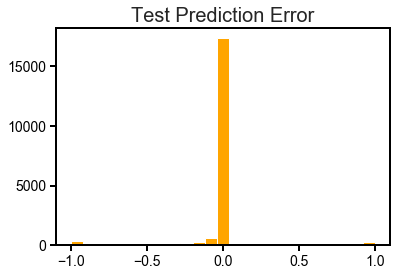

In [212]:
plt.hist(X_test['small_pred_error'],bins=25,color='orange')
plt.title("Test Prediction Error",fontsize=20)
pct = len(X_test[np.abs(X_test['small_pred_error']) < 0.2]) * 100.0 / len(X_test)
print "Percent with Error below 0.2:", pct, '%'

Percent below 0.5 96.7971530249 %
Percent above 0.5 3.20284697509 %


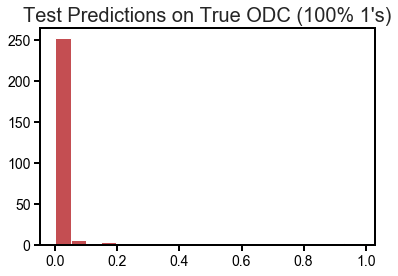

In [213]:
plt.hist(X_test_minority['small_pred_min'],bins=20,color='r')
plt.title("Test Predictions on True ODC (100% 1's)",fontsize=20)
print "Percent below 0.5", len(X_test_minority[X_test_minority['small_pred_min'] < 0.5]) * 100.0 / len(X_test_minority), '%'
print "Percent above 0.5", len(X_test_minority[X_test_minority['small_pred_min'] >= 0.5]) * 100.0 / len(X_test_minority), '%'

Percent with Error below 0.2: 1.7793594306 %


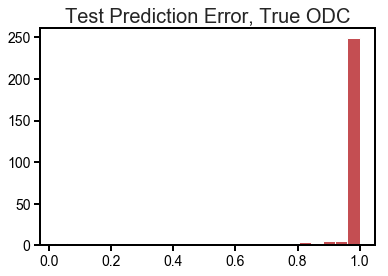

In [214]:
plt.hist(X_test_minority['small_pred_min_error'],bins=25,color='r')
plt.title("Test Prediction Error, True ODC",fontsize=20)
pct = len(X_test_minority[np.abs(X_test_minority['small_pred_min_error']) < 0.2]) * 100.0 / len(X_test_minority)
print "Percent with Error below 0.2:", pct, '%'

In [215]:
rd = count_results(X_test,'off_diagonal','small_pred')
print rd
print "% correct", 100.0 * (rd['true_pos']+rd['true_neg']) / rd['total']*1.0

{'total': 20000, 'false_pos': 2276, 'true_pos': 3, 'true_neg': 17443, 'false_neg': 278}
% correct 87.23


In [216]:
rd = count_results(X_test_minority,'off_diagonal','small_pred_min')
print rd
print "% correct", 100.0 * (rd['true_pos']+rd['true_neg']) / rd['total']*1.0

{'total': 281, 'false_pos': 0, 'true_pos': 3, 'true_neg': 0, 'false_neg': 278}
% correct 1.06761565836


## Results: Hmm. Not great

Doesn't seem to predict the minority class well, despite the up/down sampling, on either train set (the 20k with less repetition or the 200k with 200x repetition of each off-diagonal element)

# Model With More Information

What are the features?

Sequential:
- one-hot encoded sequence
- MFE of +/- 20 bp at each position (THIS SEEMS REALLY COSTLY TO COMPUTE!)
- ??

Single Number:
- Read count
- MFE of first 75, 100, 125 (previously computed)

Other:
- we could give it the polysome profile? or is that cheating? (MRL is calculated from the polysome profile)


Try first with sequence encoding + read count + mfe75, 100, 125

### Get Data For the Model

In [260]:
## Numeric Inputs
X_train_n = X_train[['scaled_total_reads','scaled_mfe75','scaled_mfe100','scaled_mfe125']].values
X_test_n = X_test[['scaled_total_reads','scaled_mfe75','scaled_mfe100','scaled_mfe125']].values

## Sequence Inputs
X_train_seq = one_hot_encode(X_train,col='utr') 
X_test_seq = one_hot_encode(X_test,col='utr') 

In [249]:
y_train = X_train['off_diagonal']
y_test = X_test['off_diagonal']

### Create Mixed Input Model

In [253]:
from keras.layers import Input
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.layers import concatenate

In [256]:
def make_dense_branch(input_features=4,n_layers=2,n_filters=10,act_fn='relu',global_dropout=0.1,
                      n_output_features=5,last_activation='relu'):
    nn = Sequential()
    nn.add(Dense(n_filters,input_shape=(input_features,),activation='relu'))
    nn.add(Dropout(global_dropout))
    for _ in range(n_layers-1):
        nn.add(Dense(n_filters,input_shape=(input_features,),activation='relu'))
        nn.add(Dropout(global_dropout))
    nn.add(Dense(n_output_features,activation=last_activation))
    return nn


In [255]:
def make_cnn_branch(input_len=50,input_features=4,n_layers=3,n_filters=20,kernel_length=8,
                    border_pad="same",act_fn='relu',dense_nodes=30,dense_dropout=0.1,
                    n_output_features=10,last_activation="relu"):
    features_dim = -1 #which one of the height,width,depth tuple has the number of features? assume last one
    cnn = Sequential()
    cnn.add(Conv1D(activation=act_fn, input_shape=(input_len,input_features), padding=border_pad,
                       filters=n_filters, kernel_size=kernel_length))
    for _ in range(n_layers-1):
        cnn.add(Conv1D(activation=act_fn, input_shape=(input_len,1), padding=border_pad,
                           filters=n_filters, kernel_size=kernel_length))
    cnn.add(Flatten())
    cnn.add(Dense(dense_nodes,activation='relu'))
    cnn.add(Dropout(dense_dropout))
#     cnn.add(BatchNormalization(axis=-1)) #CHECK THIS
    cnn.add(Dense(n_output_features,activation=last_activation))
    return cnn


In [259]:
# Create the two upstream branches
dense_nn = make_dense_branch()
cnn = make_cnn_branch()

# Create the downstream merging layers
n_merge_nodes = 40
inputs_to_combined = concatenate([dense_nn.output,cnn.output])
last_dense_layers = Dense(n_merge_nodes, activation="relu")(inputs_to_combined)
last_dense_layers = Dense(1, activation="sigmoid")(last_dense_layers)  # output single value, 
# 1 = predicted in ODC, 0 = predicted NOT in ODC

# Create the combined model
combined_model = Model(inputs=[dense_nn.input, cnn.input], outputs=last_dense_layers)


In [261]:
# # Compile and Train the Model
# np.random.seed(1337)
# adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
# combined_model.compile(loss='mean_squared_error', optimizer=adam)

# combined_model.fit([X_train_n,X_train_seq], y_train, batch_size=125, epochs=2, verbose=1) 

Epoch 1/3
200000/200000 [==============================] - 21s 106us/step - loss: 0.0622
Epoch 2/3
200000/200000 [==============================] - 19s 93us/step - loss: 0.0114
Epoch 3/3
200000/200000 [==============================] - 19s 97us/step - loss: 0.0067


In [263]:
# X_train = test_binary_data(df=X_train,model=combined_model,test_seq=[X_train_n,X_train_seq],
#                            obs_col='off_diagonal',output_col='mix_pred')
# X_test = test_binary_data(df=X_test,model=combined_model,test_seq=[X_test_n,X_test_seq],
#                           obs_col='off_diagonal',output_col='mix_pred')

In [292]:
# Try on just the Dense Branch First
dense_test = make_dense_branch(n_layers=3,n_filters=20,global_dropout=0.)
dense_test.add(Dense(1, activation='sigmoid')) # add a final prediction layer directly

np.random.seed(1337)
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
dense_test.compile(loss='mean_squared_error', optimizer=adam)

dense_test.fit(X_train_n, y_train, batch_size=125, epochs=3, verbose=1) 

Epoch 1/3
200000/200000 [==============================] - 4s 21us/step - loss: 0.1348
Epoch 2/3
200000/200000 [==============================] - 3s 14us/step - loss: 0.1179
Epoch 3/3
200000/200000 [==============================] - 3s 14us/step - loss: 0.1137: 0s - los


In [293]:
X_train = test_binary_data(df=X_train,model=combined_model,test_seq=[X_train_n,X_train_seq],
                           obs_col='off_diagonal',output_col='dense_pred')
X_test = test_binary_data(df=X_test,model=combined_model,test_seq=[X_test_n,X_test_seq],
                          obs_col='off_diagonal',output_col='dense_pred')

Percent below 0.5: 49.7305 %
Percent above 0.5: 50.2695 %


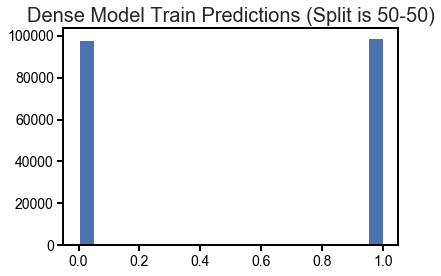

In [284]:
plt.hist(X_train['dense_pred'],bins=20)
plt.title("Dense Model Train Predictions (Split is 50-50)",fontsize=20)
print "Percent below 0.5:", len(X_train[X_train['dense_pred'] < 0.5]) * 100.0 / len(X_train), '%'
print "Percent above 0.5:", len(X_train[X_train['dense_pred'] >= 0.5]) * 100.0 / len(X_train), '%'

Percent with Error below 0.2: 99.2025 %


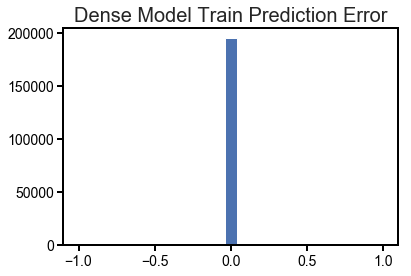

In [285]:
plt.hist(X_train['dense_pred_error'],bins=25)
plt.title("Dense Model Train Prediction Error",fontsize=20)
pct = len(X_train[np.abs(X_train['dense_pred_error']) < 0.2]) * 100.0 / len(X_train)
print "Percent with Error below 0.2:", pct, '%'

Percent below 0.5: 99.99 %
Percent above 0.5: 0.01 %


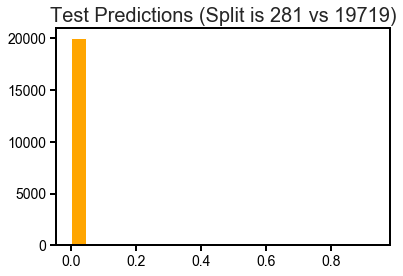

In [286]:
plt.hist(X_test['dense_pred'],bins=20,color='orange')
plt.title("Test Predictions (Split is 281 vs 19719)",fontsize=20)
print "Percent below 0.5:", len(X_test[X_test['dense_pred'] < 0.5]) * 100.0 / len(X_test), '%'
print "Percent above 0.5:", len(X_test[X_test['dense_pred'] >= 0.5]) * 100.0 / len(X_test), '%'

Percent with Error below 0.2: 98.6 %


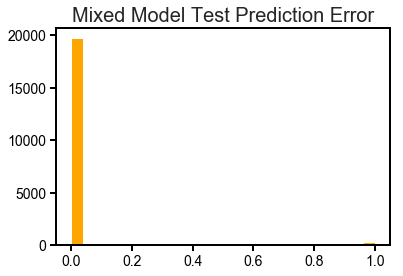

In [287]:
plt.hist(X_test['dense_pred_error'],bins=25,color='orange')
plt.title("Mixed Model Test Prediction Error",fontsize=20)
pct = len(X_test[np.abs(X_test['dense_pred_error']) < 0.2]) * 100.0 / len(X_test)
print "Percent with Error below 0.2:", pct, '%'

Percent below 0.5: 99.2882562278 %
Percent above 0.5: 0.711743772242 %


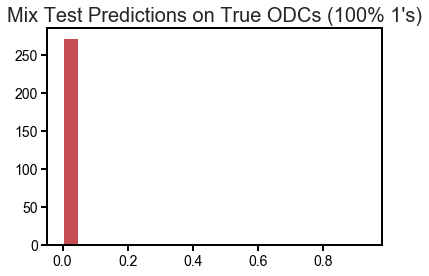

In [294]:
X_test_trueODC = X_test[X_test['off_diagonal'] == 1]
plt.hist(X_test_trueODC['dense_pred'],bins=20,color='r')
plt.title("Mix Test Predictions on True ODCs (100% 1's)",fontsize=20)
print "Percent below 0.5:",len(X_test_trueODC[X_test_trueODC['dense_pred'] < 0.5])*100.0/len(X_test_trueODC), '%'
print "Percent above 0.5:",len(X_test_trueODC[X_test_trueODC['dense_pred'] >= 0.5])*100.0/len(X_test_trueODC), '%'

Percent with Error below 0.2: 0.355871886121 %


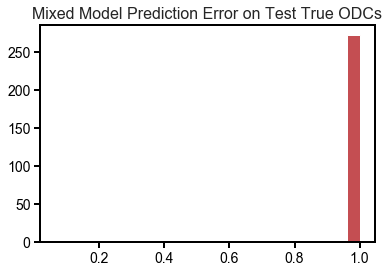

In [295]:
plt.hist(X_test_trueODC['dense_pred_error'],bins=25,color='r')
plt.title("Mixed Model Prediction Error on Test True ODCs",fontsize=16)
pct = len(X_test_trueODC[np.abs(X_test_trueODC['dense_pred_error']) < 0.2]) * 100.0 / len(X_test_trueODC)
print "Percent with Error below 0.2:", pct, '%'

In [296]:
rd = count_results(X_test_trueODC,'off_diagonal','dense_pred')
print rd
print "% correct", 100.0 * (rd['true_pos']+rd['true_neg']) / rd['total']*1.0

{'total': 281, 'false_pos': 0, 'true_pos': 0, 'true_neg': 0, 'false_neg': 281}
% correct 0.0


Note for later: you can put a validation set directly in the call to model.fit!!

In [ ]:
## EXAMPLE CODE
# model.fit(
# 	[trainAttrX, trainImagesX], trainY,
# 	validation_data=([testAttrX, testImagesX], testY),
# 	epochs=200, batch_size=8)